In [1]:
import os
import json

from itertools import chain
from tqdm import tqdm
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from skimage import morphology, filters, measure
import SimpleITK as sitk
from scipy.ndimage import binary_erosion, binary_dilation

import matplotlib.pyplot as plt

import ants


In [2]:
DIR_PELVIS = os.path.join(os.getcwd(), "..", "data", "Task1", "pelvis")
DIR_OUTPUT = os.path.join(os.getcwd(), "..", "output")
DIR_LABELS = os.path.join(os.getcwd(), "..", "labels")
FILE_MISSING = os.path.join(DIR_LABELS, "missing_Ömer.txt")
LABELS_RAW = os.path.join(DIR_LABELS, "labels_raw.json")

PATH_NYUL_NORMALIZER = os.path.join(DIR_OUTPUT, "standard_histogram.npy")
NYUL_MIN_VALUE = 0
NYUL_MAX_VALUE = 255
NYUL_MIN_PERCENTILE = 1
NYUL_MAX_PERCENTILE = 99

# list_pelvis_image_dir = [os.path.join(DIR_PELVIS, f) for f in os.listdir(DIR_PELVIS) if f.startswith("1P")]

DELTA=250
THRESH_MR_MASK = 0.1 # updated

def create_output_dirs(dir_output=DIR_OUTPUT):
    os.makedirs(dir_output, exist_ok=True)
    os.makedirs(os.path.join(dir_output, "train", "good"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "valid", "good", "img"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "valid", "good", "label"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "valid", "Ungood", "img"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "valid", "Ungood", "label"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "test", "good", "img"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "test", "good", "label"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "test", "Ungood", "img"), exist_ok=True)
    os.makedirs(os.path.join(dir_output, "test", "Ungood", "label"), exist_ok=True)

def load_nifti_image(image_path):
    img = nib.load(image_path)
    return img.get_fdata()

def apply_mask(mr_image, mask):
    if mr_image.shape != mask.shape:
        raise ValueError(f"Unmatched Image and shape {mr_image.shape} vs {mask.shape}")
    return mr_image * (mask > 0).astype(mr_image.dtype)

def center_pad_to_square_by_slice(image):
    if len(image.shape) == 2:
        return center_pad_single_slice(image)
    elif len(image.shape) == 3:
        h, w, num_slices = image.shape
        max_size = max(h, w)
        square_volume = np.zeros((max_size, max_size, num_slices), dtype=image.dtype)

        for slice_idx in range(num_slices):
            current_slice = image[:, :, slice_idx]
            square_slice = center_pad_single_slice(current_slice)
            square_volume[:, :, slice_idx] = square_slice
        return square_volume
    else:
        raise ValueError(f"Unsupported image dimensions: {image.shape}")

def center_pad_single_slice(image):
    h, w = image.shape
    max_size = max(h, w)
    
    pad_h = (max_size - h) // 2
    pad_w = (max_size - w) // 2
    
    square_slice = np.zeros((max_size, max_size), dtype=image.dtype)
    square_slice[pad_h:pad_h+h, pad_w:pad_w+w] = image

    return square_slice, (pad_h, pad_w)

def center_pad_single_slice_by_params(image, pad_h, pad_w):
    h, w = image.shape
    max_size = max(h, w)

    square_slice = np.zeros((max_size, max_size), dtype=image.dtype)
    square_slice[pad_h:pad_h+h, pad_w:pad_w+w] = image
    return square_slice

def center_pad_to_square(image):
    h, w = image.shape[:2]
    max_size = max(h, w)
    
    pad_h = (max_size - h) // 2
    pad_w = (max_size - w) // 2
    
    if len(image.shape) == 2:
        square_image = np.zeros((max_size, max_size), dtype=image.dtype)
        square_image[pad_h:pad_h+h, pad_w:pad_w+w] = image
    else:
        square_image = np.zeros((max_size, max_size, image.shape[2]), dtype=image.dtype)
        square_image[pad_h:pad_h+h, pad_w:pad_w+w, :] = image
    
    return square_image

def resize_image(image, target_size=[240, 240]):
    """Resize the image to the target size."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST_EXACT)


def n4_bias_correction(image, mask):
    image = ants.from_numpy(image.astype(np.float32, copy=False))
    mask = ants.from_numpy(mask.astype(np.float32, copy=False))
    return ants.n4_bias_field_correction(
        image=image,
        mask=mask,
        shrink_factor=3,
        spline_param=[100, 100, 120],
        convergence={"iters": [50, 50, 20], "tol": 1e-3},
        verbose=False,
    )

def minmax_normalize_numpy(volume, clip_range=(0, 2000)):
    v = volume.astype(np.float32)
    v = v.clip(*clip_range)
    v_min, v_max = np.min(v), np.max(v)
    if v_max > v_min:  # avoid divide by zero
        v = (v - v_min) / (v_max - v_min) * 255
    else:
        v = np.zeros_like(v)
    return v.astype(np.uint8)

In [3]:
class MetalArtifactDetector:
    def __init__(self, metric='f1'):
        """
        metric: ('f1', 'youden', 'balanced_acc', 'recall', 'precision', 'accuracy')
        """
        self.metric = metric
        self.tau_global = None
        self.tau_map = {}

    @staticmethod
    def _confusion_binary(y_true, y_pred):
        y_true = np.asarray(y_true, dtype=np.uint8)
        y_pred = np.asarray(y_pred, dtype=np.uint8)
        tp = int(np.sum((y_true == 1) & (y_pred == 1)))
        tn = int(np.sum((y_true == 0) & (y_pred == 0)))
        fp = int(np.sum((y_true == 0) & (y_pred == 1)))
        fn = int(np.sum((y_true == 1) & (y_pred == 0)))
        return tp, fp, fn, tn

    @staticmethod
    def _metrics_from_cm(tp, fp, fn, tn, eps=1e-9):
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1   = 2 * prec * rec / (prec + rec + eps)
        tpr  = rec
        tnr  = tn / (tn + fp + eps)
        bal_acc = 0.5 * (tpr + tnr)
        youden  = tpr + tnr - 1.0
        acc     = (tp + tn) / (tp + fp + fn + tn + eps)
        return {
            "precision": prec, "recall": rec, "f1": f1,
            "balanced_acc": bal_acc, "youden": youden, "accuracy": acc
        }

    @staticmethod
    def _norm01(x, hu_window=None, clip_quantiles=None, eps=1e-6):
        x = np.asarray(x, dtype=float)
        if hu_window is not None:
            lo, hi = hu_window
            x = np.clip(x, lo, hi)
        elif clip_quantiles is not None:
            qlo, qhi = clip_quantiles
            lo = np.percentile(x, qlo*100.0)
            hi = np.percentile(x, qhi*100.0)
            x = np.clip(x, lo, hi)
        mn, mx = x.min(), x.max()
        if mx - mn < eps:
            return np.zeros_like(x)
        return (x - mn) / (mx - mn + eps)

    def score_volume_hu(self, vol, scan_id="scan1", slice_axis=0):
        """return max HU for each slice"""
        vol_z = np.moveaxis(vol, slice_axis, 0)  # (Z,H,W)
        z, h, w = vol_z.shape
        slice_max = np.max(vol_z.reshape(z, -1), axis=1)
        return pd.DataFrame({
            "scan_id": scan_id,
            "slice_idx": np.arange(z),
            "slice_max_hu": slice_max.astype(float),
        })

    def pick_global_tau_by_hu(self, df, metal_slices=None,
                              label_col='label', hu_col='slice_max_hu'):
        """
        global_tau = max(max_normal_hu, min_max_abnormal_hu)
        """
        if metal_slices is None:
            if label_col not in df.columns:
                raise ValueError("Need metal_slices or df[label_col].")
            labels = df[label_col].values.astype(int)
            pos_idx = np.where(labels == 1)[0]
            neg_idx = np.where(labels == 0)[0]
        else:
            sl = df["slice_idx"].values
            pos_mask = np.isin(sl, np.asarray(metal_slices, dtype=int))
            pos_idx = np.where(pos_mask)[0]
            neg_idx = np.where(~pos_mask)[0]

        vals = df[hu_col].values.astype(float)

        max_normal_hu = float(vals[neg_idx].max()) if len(neg_idx) > 0 else -np.inf
        min_max_abnormal_hu = float(vals[pos_idx].min()) if len(pos_idx) > 0 else np.inf

        global_tau = max(max_normal_hu, min_max_abnormal_hu)
        self.tau_global = global_tau
        return global_tau, {
            "max_normal_hu": max_normal_hu,
            "min_max_abnormal_hu": min_max_abnormal_hu
        }

    def apply_tau_by_hu(self, df, hu_col='slice_max_hu'):
        """classify slices based on HU values"""
        if self.tau_global is None or not np.isfinite(self.tau_global):
            raise ValueError("Global tau not set. Run pick_global_tau_by_hu first.")
        out = df.copy()
        out["pred"] = (out[hu_col].values >= self.tau_global).astype(np.uint8)
        return out

    def evaluate(self, df, label_col='label', pred_col='pred', scan_col='scan_id'):
        # slice-level
        tp, fp, fn, tn = self._confusion_binary(df[label_col].values, df[pred_col].values)
        sl = self._metrics_from_cm(tp, fp, fn, tn)
        sl.update(dict(tp=tp, fp=fp, fn=fn, tn=tn))

        # scan-level
        scan_true = df.groupby(scan_col, sort=False)[label_col].max().values
        scan_pred = df.groupby(scan_col, sort=False)[pred_col].max().values
        tp, fp, fn, tn = self._confusion_binary(scan_true, scan_pred)
        sc = self._metrics_from_cm(tp, fp, fn, tn)
        sc.update(dict(tp=tp, fp=fp, fn=fn, tn=tn))
        return {"slice_level": sl, "scan_level": sc}


    def extract_mask_volume(self, vol, tau, slice_axis=0):
        return (vol >= tau).astype(np.uint8)

    def postprocess_mask(self, mask2d, min_hole_size=20, smooth=True, disk_size=3):
        mask = mask2d.astype(bool)

        mask = morphology.remove_small_holes(mask, area_threshold=min_hole_size)

        if smooth:
            selem = morphology.disk(disk_size)
            mask = morphology.binary_opening(mask, selem)
            mask = morphology.binary_closing(mask, selem)

        return mask.astype(np.uint8)

    def postprocess_mask_volume(self, mask_vol, slice_axis=0,
                                min_hole_size=20, smooth=True, disk_size=0):
        vol_z = np.moveaxis(mask_vol, slice_axis, 0)
        out_z = []
        for z in range(vol_z.shape[0]):
            out_z.append(self.postprocess_mask(vol_z[z],
                                               min_hole_size=min_hole_size,
                                               smooth=smooth,
                                               disk_size=disk_size))
        out = np.stack(out_z, axis=0)
        return np.moveaxis(out, 0, slice_axis)
    
    def show_ct_mask_mr(
        self, ct_vol, mr_vol, raw_mask_vol, post_mask_vol, slice_indices,
        body_mask = None,
        slice_axis=0, suptitle="CT (raw vs postprocessed mask) & MR",
        ct_hu_window=None, ct_clip_quantiles=None,
        mr_clip_quantiles=None,
        fill_alpha=0.6, outline_width=1.5,
        raw_color=(0.0, 0, 1.0),   # blue
        post_color=(0.0, 1.0, 0.0), # green
        outline_color="red",
        figsize=(12, 3)
    ):
        if isinstance(slice_indices, int):
            slice_indices = [slice_indices]

        ct = np.moveaxis(ct_vol, slice_axis, 0)
        mr = np.moveaxis(mr_vol, slice_axis, 0)
        if body_mask is not None:
            # ValueError: operands could not be broadcast together with shapes (149,428,277) (428,277,149) 
            mr = mr * np.moveaxis(body_mask, slice_axis, 0)

        raw_mask = np.moveaxis(raw_mask_vol, slice_axis, 0)
        post_mask = np.moveaxis(post_mask_vol, slice_axis, 0)

        print(ct.shape, mr.shape, raw_mask.shape, post_mask.shape)
        assert ct.shape == mr.shape == raw_mask.shape == post_mask.shape, "Shapes must match"

        n = len(slice_indices)
        fig, axs = plt.subplots(n, 3, figsize=(figsize[0], figsize[1] * n))

        if n == 1:
            axs = np.expand_dims(axs, 0)

        for i, z in enumerate(slice_indices):
            ct_img = self._norm01(ct[z], hu_window=ct_hu_window, clip_quantiles=ct_clip_quantiles)
            mr_img = self._norm01(mr[z], clip_quantiles=mr_clip_quantiles)
            raw_mask_img = raw_mask[z].astype(bool)
            post_mask_img = post_mask[z].astype(bool)

            ct_img  = np.rot90(ct_img,  k=-1)
            mr_img  = np.rot90(mr_img,  k=-1)
            raw_mask_img  = np.rot90(raw_mask_img,  k=-1)
            post_mask_img = np.rot90(post_mask_img, k=-1)

            # CT + raw mask
            axs[i, 0].imshow(ct_img, cmap="gray")
            overlay_raw = np.zeros((*raw_mask_img.shape, 4), dtype=float)
            r, g, b = raw_color
            overlay_raw[raw_mask_img] = [r, g, b, float(fill_alpha)]
            axs[i, 0].imshow(overlay_raw)
            contours = measure.find_contours(raw_mask_img, level=0.5)
            for contour in contours:
                axs[i, 0].plot(contour[:, 1], contour[:, 0], color=outline_color, linewidth=outline_width)
            axs[i, 0].set_title(f"Raw Mask+CT z={z}")
            axs[i, 0].axis("off")

            # CT + postprocessed mask
            axs[i, 1].imshow(ct_img, cmap="gray")
            overlay_post = np.zeros((*post_mask_img.shape, 4), dtype=float)
            r, g, b = post_color
            overlay_post[post_mask_img] = [r, g, b, float(fill_alpha)]
            axs[i, 1].imshow(overlay_post)
            contours = measure.find_contours(post_mask_img, level=0.5)
            for contour in contours:
                axs[i, 1].plot(contour[:, 1], contour[:, 0], color=outline_color, linewidth=outline_width)
            axs[i, 1].set_title(f"Post Mask+CT z={z}")
            axs[i, 1].axis("off")

            # MR
            axs[i, 2].imshow(mr_img, cmap="gray")
            axs[i, 2].set_title(f"MR z={z}")
            axs[i, 2].axis("off")

        plt.suptitle(suptitle, fontsize=14)
        plt.tight_layout()
        plt.show()

    def get_mask_biggest_contour(self, mask_ct):
        for i in range(mask_ct.shape[2]):
            inmask = np.expand_dims(mask_ct[:, :, i].astype(np.uint8), axis=2)
            ret, bin_img = cv2.threshold(inmask, 0.5, 1, cv2.THRESH_BINARY)
            (cnts, _) = cv2.findContours(np.expand_dims(bin_img, axis=2), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # return None, if no contours detected
            if len(cnts) != 0:
                # based on contour area, get the maximum contour which is a body contour
                segmented = max(cnts, key=cv2.contourArea)
                bin_img[bin_img > 0] = 0
                a = cv2.drawContours(np.expand_dims(bin_img, axis=2), [segmented], 0, (255, 255, 255), -1)
                a[a > 0] = 1
                mask_ct[:, :, i] = a.squeeze()
        return mask_ct.astype(np.uint8)

    def get_body_mask_threshold(self, nii_array, threshold_ct_body_mask):
        mask_ct = np.zeros(nii_array.shape)
        mask_ct[nii_array > threshold_ct_body_mask] = 1
        mask_ct[nii_array <= threshold_ct_body_mask] = 0
        mask_ct = binary_erosion(mask_ct, iterations=2).astype(np.uint8)
        mask_ct = self.get_mask_biggest_contour(mask_ct)
        mask_ct = binary_dilation(mask_ct, iterations=5).astype(np.int16)
        return mask_ct
    
    
    def refine_mask_with_mr(self, ct_mask_vol, mr_vol, lo_diff=10, up_diff=150, min_contour_area=5):
        """
        Refines a 3D CT mask volume using a corresponding MR volume by performing
        a flood-fill operation on each slice. Handles small, single-pixel anomalies
        by preserving the original CT mask.

        Args:
            ct_mask_vol (np.ndarray): The 3D volume of the initial CT masks (binary, uint8).
            mr_vol (np.ndarray): The 3D volume of the MR images.
            lo_diff (int): The lower boundary difference from the seed pixel's value.
            up_diff (int): The upper boundary difference from the seed pixel's value.
                           These values determine the sensitivity to gradient changes.
            min_contour_area (int): The minimum area of a contour to trigger the flood fill.
                                    If a contour is smaller than this, the original mask is used.

        Returns:
            np.ndarray: The refined 3D mask volume (binary, uint8).
        """
        print(ct_mask_vol.shape, mr_vol.shape)
        assert ct_mask_vol.shape == mr_vol.shape, f"CT mask-{ct_mask_vol.shape}, MR-{mr_vol.shape} must have the same shape"
        
        # Create an empty volume to store the refined masks
        refined_mask = np.zeros_like(ct_mask_vol, dtype=np.uint8)

        # Iterate over each slice in the 3D volumes
        for i in range(ct_mask_vol.shape[2]):
            slice_ct = ct_mask_vol[:, :, i].astype(np.uint8)
            slice_mr = mr_vol[:, :, i]

            # If there's no mask on this slice, skip it
            if slice_ct.sum() == 0:
                continue

            # Find all contours on this slice
            contours, _ = cv2.findContours(slice_ct, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if not contours:
                continue

            # This will store the combined result of all flood fills and preserved masks
            refined_mask_slice = np.zeros_like(slice_ct)

            for cnt in contours:
                contour_area = cv2.contourArea(cnt)
                
                # Check if the contour is too small for flood fill
                if contour_area < min_contour_area:
                    # If it's too small, just keep the original mask for this area
                    mask_cnt = np.zeros(slice_ct.shape, dtype=np.uint8)
                    cv2.drawContours(mask_cnt, [cnt], -1, 1, -1)
                    refined_mask_slice = np.logical_or(refined_mask_slice, mask_cnt).astype(np.uint8)
                    continue

                # Calculate the centroid (x, y) coordinates for this contour
                M = cv2.moments(cnt)
                if M["m00"] == 0:
                    continue
                
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                
                # --- Perform the flood-fill operation for this specific contour ---
                flood_fill_slice = slice_mr.copy().astype(np.float32)

                # Create an empty mask to store the result of the flood fill.
                h, w = flood_fill_slice.shape
                mask = np.zeros((h + 2, w + 2), np.uint8)

                cv2.floodFill(flood_fill_slice, mask, (cx, cy), 255, lo_diff, up_diff, cv2.FLOODFILL_MASK_ONLY)

                # Remove the extra border from the mask to get the final refined mask for the slice.
                current_fill = mask[1:-1, 1:-1]
                
                # Combine the new flood fill result with the existing refined mask for the slice
                refined_mask_slice = np.logical_or(refined_mask_slice, current_fill).astype(np.uint8)

            refined_mask[:, :, i] = refined_mask_slice

        return refined_mask

## Train Test Split

In [4]:
df_overview = pd.read_excel("/home/user/lyeyang/projects/sct-ood-dataset/data/Task1/pelvis/overview/1_pelvis_train.xlsx",
                            sheet_name="MR",)
ids_all = df_overview["ID"].tolist()
ids_all = [i for i in ids_all if i.startswith("1PA")]

with open("/home/user/lyeyang/projects/sct-ood-dataset/labels/labels_raw.json") as f:
    data = json.load(f)

data_abnormal = data['type1']

ids_abnormal = [list(item.keys())[0] for item in data['type1']]
ids_abnormal = [i for i in ids_abnormal if i.startswith("1PA")] # TODO:

df_labels_1 = pd.DataFrame([
    {"id": k, **v} 
    for item in data_abnormal 
    for k, v in item.items()
])
list_na_ids = df_labels_1[df_labels_1.isna().any(axis=1)]['id'].tolist()

df_labels_1 = df_labels_1.dropna()
df_labels_1 = df_labels_1[df_labels_1['body_part'] == 'pelvis']

df_labels_1["anomaly_start"] = df_labels_1[["ct_start", "mr_start"]].min(axis=1)
df_labels_1["anomaly_end"] = df_labels_1[["ct_end", "mr_end"]].max(axis=1)

anomaly_range = {id: (int(start), int(end)) for id, start, end 
                 in zip(df_labels_1["id"], df_labels_1["anomaly_start"], df_labels_1["anomaly_end"])}

In [5]:
# with open("/home/user/lyeyang/projects/sct-ood-dataset/labels/Justin.txt") as f:
#     ids_justin = f.read().splitlines()

ids_abnormal_all = df_labels_1['id'].tolist()
with open("../labels/missing_Ömer.txt") as f:
    ids_omer = f.read().splitlines()

ids_not_included = list_na_ids + ids_omer

ids_used = list(set(ids_all) - set(ids_not_included))

ids_abnormal = list(set(ids_used) & set(ids_abnormal))
ids_normal = list(set(ids_used) - set(ids_abnormal))

In [6]:
ids_abnormal_valid = ["1PA133", "1PA136", "1PA169", "1PA178", '1PC015', '1PC037'] #  
ids_normal_valid = ['1PA171', '1PA156', '1PA119', '1PA113', '1PA100', '1PA177', '1PC032', '1PC080', '1PC000'] # 

ids_abnormal_test = list(set(ids_abnormal) - set(ids_abnormal_valid))
ids_normal_test = list(set(ids_normal)-set(ids_normal_valid))[::3]
# ids_normal_test = ['1PA134', '1PA157', '1PA146', '1PA141', '1PA140']
ids_normal_train = list(set(ids_normal) - set(ids_normal_valid) - set(ids_normal_test))
ids_abnormal_valid

['1PA133', '1PA136', '1PA169', '1PA178', '1PC015', '1PC037']

In [7]:
print("Stats of data")
print(f"Used IDs: {len(ids_used)}")
print(f"Abnormal IDs: {len(ids_abnormal)}")
print(f"Normal IDs: {len(ids_normal)}")
print(f"Valid Abnormal IDs: {len(ids_abnormal_valid)}")
print(f"Valid Normal IDs: {len(ids_normal_valid)}")
print(f"Test Abnormal IDs: {len(ids_abnormal_test)}")
print(f"Test Normal IDs: {len(ids_normal_test)}")
print(f"Train Normal IDs: {len(ids_normal_train)}")

Stats of data
Used IDs: 81
Abnormal IDs: 23
Normal IDs: 58
Valid Abnormal IDs: 6
Valid Normal IDs: 9
Test Abnormal IDs: 19
Test Normal IDs: 18
Train Normal IDs: 36


# out

## Nyul Normalizer

In [13]:
import glob
import os

list_problematic_images = []
def analyze_data_quality():
    print("=== Data Quality Analysis ===")

    for img_f in glob.glob('/home/user/lyeyang/projects/sct-ood-dataset/nyul_work/imgs/*.nii*')[:]:  # 检查前3个文件
        print(f"\nAnalyzing: {os.path.basename(img_f)}")
        
        img_data = nib.load(img_f).get_fdata()
        mask_f = img_f.replace('/imgs/', '/masks/')
        mask_data = nib.load(mask_f).get_fdata()
        
        masked_data = img_data[mask_data > 0]
        
        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        p_values = np.percentile(masked_data, percentiles)
        
        
        if len(set(p_values)) < len(p_values):
            print(f"  Percentiles: {dict(zip(percentiles, p_values))}")
            list_problematic_images.append(img_f)
            print(f"  WARNING: Some percentiles have identical values!")
            print(f"  This will cause division by zero in Nyul algorithm")

# analyze_data_quality()

In [8]:
create_output_dirs()

In [15]:
# Train: good only
for id_ in ids_normal_train:
    dir_scan = os.path.join(DIR_PELVIS, id_)
    path_mr = os.path.join(dir_scan, "mr.nii.gz")
    path_mask = os.path.join(dir_scan, "mask.nii.gz")
    path_ct = os.path.join(dir_scan, "ct.nii.gz")

    mr_image = load_nifti_image(path_mr)
    ct_image = load_nifti_image(path_ct)
    mask = load_nifti_image(path_mask)

    det = MetalArtifactDetector()
    body_mask = det.get_body_mask_threshold(mr_image * mask, threshold_ct_body_mask=THRESH_MR_MASK)
    body_mask = np.logical_and(body_mask>0, mask > 0)

    masked_mr = apply_mask(mr_image, body_mask)
    mr_normalized = minmax_normalize_numpy(masked_mr)
    
    slices = mr_image.shape[2]

    for i in tqdm(range(25, slices - 20, 1)):
        slice_image = masked_mr[:, :, i]
        slice_image_centered, (pad_h, pad_w) = center_pad_single_slice(slice_image)
        slice_image_resized = resize_image(slice_image_centered, target_size=[240, 240])
        
        plt.imsave(os.path.join(DIR_OUTPUT, "train", "good", f"{id_}_{i}.png"), slice_image_resized, cmap="bone")


100%|██████████| 81/81 [00:01<00:00, 42.14it/s]


In [16]:
# Valid: good only
for id_ in ids_normal_valid:
    dir_scan = os.path.join(DIR_PELVIS, id_)
    path_mr = os.path.join(dir_scan, "mr.nii.gz")
    
    path_mask = os.path.join(dir_scan, "mask.nii.gz")
    path_ct = os.path.join(dir_scan, "ct.nii.gz")

    mr_image = load_nifti_image(path_mr)
    ct_image = load_nifti_image(path_ct)
    mask = load_nifti_image(path_mask)

    body_mask = det.get_body_mask_threshold(mr_image * mask, threshold_ct_body_mask=THRESH_MR_MASK)
    body_mask = np.logical_and(body_mask>0, mask > 0)

    masked_mr = apply_mask(mr_image, body_mask)
    mr_normalized = minmax_normalize_numpy(masked_mr)
    
    slices = mr_image.shape[2]

    for i in tqdm(range(25, slices - 20, 1)):
        slice_image = masked_mr[:, :, i]
        slice_image_centered, (pad_h, pad_w) = center_pad_single_slice(slice_image)
        slice_image_resized = resize_image(slice_image_centered, target_size=[240, 240])
        slice_mask = np.zeros_like(slice_image_resized)
        plt.imsave(os.path.join(DIR_OUTPUT, "valid", "good", "img", f"{id_}_{i}.png"), slice_image_resized, cmap="bone")
        plt.imsave(os.path.join(DIR_OUTPUT, "valid", "good", "label", f"{id_}_{i}.png"), slice_mask, cmap="bone")

100%|██████████| 41/41 [00:01<00:00, 38.99it/s]


In [13]:
# Valid: Ungood
for id_ in ids_abnormal_valid:
    dir_scan = os.path.join(DIR_PELVIS, id_)
    path_mr = os.path.join(dir_scan, "mr.nii.gz")

    path_mask = os.path.join(dir_scan, "mask.nii.gz")
    path_ct = os.path.join(dir_scan, "ct.nii.gz")

    mr_image = load_nifti_image(path_mr)
    ct_image = load_nifti_image(path_ct)
    mask = load_nifti_image(path_mask)
    
    det = MetalArtifactDetector()

    body_mask = det.get_body_mask_threshold(mr_image * mask, threshold_ct_body_mask=THRESH_MR_MASK)
    body_mask = np.logical_and(body_mask>0, mask > 0)

    masked_mr = apply_mask(mr_image, body_mask)
    mr_normalized = minmax_normalize_numpy(masked_mr)

    slices = mr_image.shape[2]
    abnormal_slices = list(range(anomaly_range[id_][0], anomaly_range[id_][-1]))
    
    # Extract label masks
    df_hu = det.score_volume_hu(ct_image, scan_id=id_, slice_axis=2)
    df_hu["label"] = np.isin(df_hu["slice_idx"], abnormal_slices).astype(np.uint8)
    tau, info = det.pick_global_tau_by_hu(df_hu, label_col="label")
    print("tau:", tau, "| info:", info)
    tau -= DELTA
    mask_vol = (ct_image >= tau).astype(np.uint8)

    abnormal_slices = [i for i in abnormal_slices if i >= 15 and i < slices - 15]
    print(id_, "abnormal slices:", abnormal_slices)

    mask_vol_refined = det.refine_mask_with_mr(mask_vol, masked_mr, lo_diff=lo_diff_val, up_diff=up_diff_val)
    mask_vol_refined = det.postprocess_mask_volume(mask_vol_refined, min_hole_size=20, smooth=True, disk_size=0)
    mask_vol = mask_vol_refined

    for i in tqdm(abnormal_slices):
        slice_image = masked_mr[:, :, i]
        slice_mask = mask_vol[:, :, i]

        lo_diff_val = 5
        up_diff_val = 10        
        
        slice_image_centered, (pad_h, pad_w) = center_pad_single_slice(slice_image)
        slice_mask = center_pad_single_slice_by_params(slice_mask, pad_h, pad_w)

        slice_image_resized = resize_image(slice_image_centered, target_size=[240, 240])
        slice_mask = resize_image(slice_mask, target_size=[240, 240])

        if slice_mask.sum()<3:
            # print(f"Skipping slice {i} for {id_} due to insufficient mask data.")
            continue

        plt.imsave(os.path.join(DIR_OUTPUT, "valid", "Ungood", "img", f"{id_}_{i}.png"), slice_image_resized, cmap="bone")
        plt.imsave(os.path.join(DIR_OUTPUT, "valid", "Ungood", "label", f"{id_}_{i}.png"), slice_mask, cmap="bone")

tau: 1619.0 | info: {'max_normal_hu': 1619.0, 'min_max_abnormal_hu': 1087.0}
1PA133 abnormal slices: [74, 75, 76, 77, 78, 79, 80, 81]
(428, 277, 149) (428, 277, 149)


100%|██████████| 8/8 [00:00<00:00, 109.56it/s]


tau: 3000.0 | info: {'max_normal_hu': 3000.0, 'min_max_abnormal_hu': 1081.0}
1PA136 abnormal slices: [98, 99, 100, 101, 102, 103, 104, 105, 106]
(454, 268, 122) (454, 268, 122)


100%|██████████| 9/9 [00:00<00:00, 73.36it/s]


tau: 1483.0 | info: {'max_normal_hu': 1483.0, 'min_max_abnormal_hu': 1047.0}
1PA169 abnormal slices: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
(478, 338, 122) (478, 338, 122)


100%|██████████| 82/82 [00:01<00:00, 41.69it/s]


tau: 1498.0 | info: {'max_normal_hu': 1498.0, 'min_max_abnormal_hu': 1163.0}
1PA178 abnormal slices: [44, 45, 46, 47, 48, 49, 50]
(482, 289, 115) (482, 289, 115)


100%|██████████| 7/7 [00:00<00:00, 47.02it/s]


tau: 3000.0 | info: {'max_normal_hu': 3000.0, 'min_max_abnormal_hu': 1068.0}
1PC015 abnormal slices: [15, 16, 17, 18, 19, 20]
(466, 324, 85) (466, 324, 85)


100%|██████████| 6/6 [00:00<00:00, 279.77it/s]


tau: 3000.0 | info: {'max_normal_hu': 3000.0, 'min_max_abnormal_hu': 1104.0}
1PC037 abnormal slices: [15]
(418, 289, 87) (418, 289, 87)


100%|██████████| 1/1 [00:00<00:00, 96.94it/s]


In [ ]:
# Test: good only
for id_ in ids_normal_test:
    dir_scan = os.path.join(DIR_PELVIS, id_)
    path_mr = os.path.join(dir_scan, "mr.nii.gz")
    
    path_mask = os.path.join(dir_scan, "mask.nii.gz")
    path_ct = os.path.join(dir_scan, "ct.nii.gz")

    mr_image = load_nifti_image(path_mr)
    ct_image = load_nifti_image(path_ct)
    mask = load_nifti_image(path_mask)

    det = MetalArtifactDetector()
    
    body_mask = det.get_body_mask_threshold(mr_image * mask, threshold_ct_body_mask=THRESH_MR_MASK)
    body_mask = np.logical_and(body_mask>0, mask > 0)

    

    masked_mr = apply_mask(mr_image, body_mask)
    mr_normalized = minmax_normalize_numpy(masked_mr)

    slices = mr_image.shape[2]

    for i in tqdm(range(25, slices - 20, 1)):
        slice_image = masked_mr[:, :, i]
        slice_image_centered, (pad_h, pad_w) = center_pad_single_slice(slice_image)
        slice_image_resized = resize_image(slice_image_centered, target_size=[240, 240])
        slice_mask = np.zeros_like(slice_image_resized)
        plt.imsave(os.path.join(DIR_OUTPUT, "test", "good", "img", f"{id_}_{i}.png"), slice_image_resized, cmap="bone")
        plt.imsave(os.path.join(DIR_OUTPUT, "test", "good", "label", f"{id_}_{i}.png"), slice_mask, cmap="bone")

100%|██████████| 91/91 [00:02<00:00, 37.91it/s]


In [ ]:
# Test: Ungood
for id_ in ids_abnormal_test:
    dir_scan = os.path.join(DIR_PELVIS, id_)
    path_mr = os.path.join(dir_scan, "mr.nii.gz")

    path_mask = os.path.join(dir_scan, "mask.nii.gz")
    path_ct = os.path.join(dir_scan, "ct.nii.gz")

    mr_image = load_nifti_image(path_mr)
    ct_image = load_nifti_image(path_ct)
    mask = load_nifti_image(path_mask)

    det = MetalArtifactDetector()
    body_mask = det.get_body_mask_threshold(mr_image * mask, threshold_ct_body_mask=THRESH_MR_MASK)
    body_mask = np.logical_and(body_mask>0, mask > 0)

    masked_mr = apply_mask(mr_image, body_mask)
    mr_normalized = minmax_normalize_numpy(masked_mr)
    
    slices = mr_image.shape[2]
    abnormal_slices = list(range(anomaly_range[id_][0], anomaly_range[id_][-1]))
    
    # Extract label masks
    
    df_hu = det.score_volume_hu(ct_image, scan_id=id_, slice_axis=2)
    df_hu["label"] = np.isin(df_hu["slice_idx"], abnormal_slices).astype(np.uint8)
    tau, info = det.pick_global_tau_by_hu(df_hu, label_col="label")
    print("tau:", tau, "| info:", info)
    tau -= DELTA
    mask_vol = (ct_image >= tau).astype(np.uint8)
    
    abnormal_slices = [i for i in abnormal_slices if i >= 15 and i < slices - 15]

    lo_diff_val = 5
    up_diff_val = 10
    mask_vol_refined = det.refine_mask_with_mr(mask_vol, masked_mr, lo_diff=lo_diff_val, up_diff=up_diff_val)
    mask_vol_refined = det.postprocess_mask_volume(mask_vol_refined, min_hole_size=20, smooth=True, disk_size=0)
    mask_vol = mask_vol_refined

    for i in tqdm(abnormal_slices):
        slice_image = masked_mr[:, :, i]
        slice_mask = mask_vol[:, :, i]

        slice_image_centered, (pad_h, pad_w) = center_pad_single_slice(slice_image)
        slice_mask = center_pad_single_slice_by_params(slice_mask, pad_h, pad_w)

        slice_image_resized = resize_image(slice_image_centered, target_size=[240, 240])
        slice_mask = resize_image(slice_mask, target_size=[240, 240])

        if slice_mask.sum()<3:
            continue

        plt.imsave(os.path.join(DIR_OUTPUT, "test", "Ungood", "img", f"{id_}_{i}.png"), slice_image_resized, cmap="bone")
        plt.imsave(os.path.join(DIR_OUTPUT, "test", "Ungood", "label", f"{id_}_{i}.png"), slice_mask, cmap="bone")

tau: 1445.0 | info: {'max_normal_hu': 1445.0, 'min_max_abnormal_hu': 958.0}
(411, 263, 130) (411, 263, 130)


  0%|          | 0/37 [00:00<?, ?it/s]

(411, 263) (411, 263, 130)


AssertionError: CT mask-(411, 263), MR-(411, 263, 130) must have the same shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from PIL import Image

def plot_mr_with_and_without_mask(
    mr_image_path,
    mask_image_path,
    alpha=0.4,
    figsize=(10, 5),
    mask_color="red"
):
    mr = np.array(Image.open(mr_image_path).convert("F"))  # grayscale float
    mask = np.array(Image.open(mask_image_path))

    if mask.ndim == 3:
        mask = np.array(Image.fromarray(mask).convert("L"))

    if mask.dtype.kind not in "iu":
        mask = (mask > 0).astype(np.uint8)

    if mask.shape != mr.shape:
        mask = np.array(Image.fromarray(mask).resize(mr.shape[::-1], Image.NEAREST))

    finite = np.isfinite(mr)
    vmin, vmax = np.percentile(mr[finite], [2, 98]) if finite.any() else (None, None)

    overlay_cmap = ListedColormap([to_rgba(mask_color)])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    for ax in (ax1, ax2): ax.axis("off")

    ax1.imshow(mr, cmap="gray", vmin=vmin, vmax=vmax)
    ax1.set_title("Original MR")

    ax2.imshow(mr, cmap="gray", vmin=vmin, vmax=vmax)
    ax2.imshow(np.ma.masked_where(mask == 0, mask),
               cmap=overlay_cmap, alpha=alpha, interpolation="none")
    ax2.set_title("MR + Mask")

    plt.tight_layout()
    plt.show()
    return fig, (ax1, ax2)


In [ ]:
examples = [
    ("1PA133",74,82,"Bright spots on CT, black spots on MR."),
    ("1PA136",100,121,"Artifact due two metal nail in spine."),
    ("1PA147",45,53,"Bright spots on CT, hard to tell on MR."),
    ("1PA151",46,54,"Some bright spots visible (local radiotherapy with implants) in CT difficult to spot in MR."),
    ("1PA152",56,68,"Weird bright short little lines in CT, MR shows black spots. Not as bright as other cases."),
    ("1PA169",8,82,"OOD due to hip implant.")
]

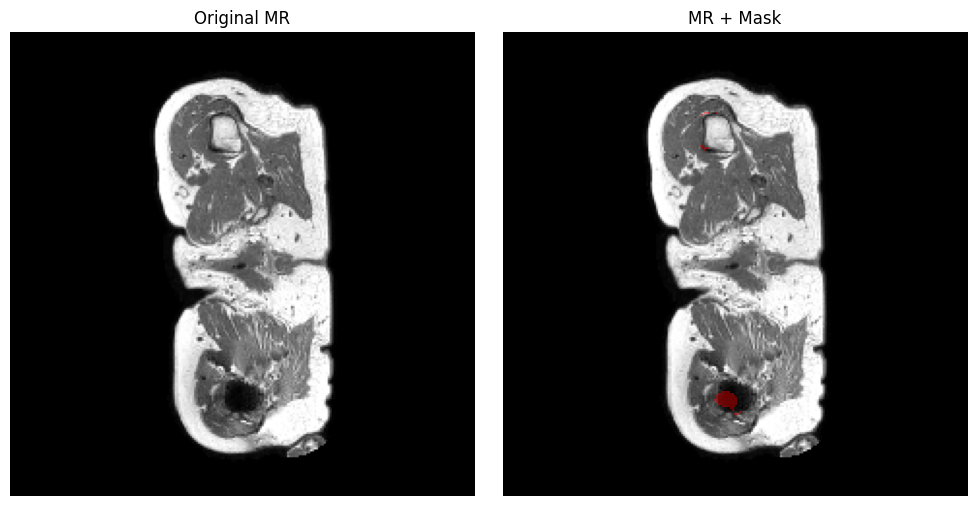

(<Figure size 1000x500 with 2 Axes>,
 (<Axes: title={'center': 'Original MR'}>,
  <Axes: title={'center': 'MR + Mask'}>))

In [ ]:
mr_example_path = "/home/user/lyeyang/projects/sct-ood-dataset/output/test/Ungood/img/1PA118_31.png"
mask_example_path = "/home/user/lyeyang/projects/sct-ood-dataset/output/test/Ungood/label/1PA118_31.png"
plot_mr_with_and_without_mask(mr_example_path, mask_example_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from PIL import Image

def _load_and_prepare(mr_image_path, mask_image_path):
    """Helper: load MR as float grayscale, mask as uint8 {0,1}, match shape."""
    mr = np.array(Image.open(mr_image_path).convert("F"))  # grayscale float

    mask = np.array(Image.open(mask_image_path))
    if mask.ndim == 3:
        mask = np.array(Image.fromarray(mask).convert("L"))
    if mask.dtype.kind not in "iu":
        mask = (mask > 0).astype(np.uint8)
    if mask.shape != mr.shape:
        mask = np.array(Image.fromarray(mask).resize(mr.shape[::-1], Image.NEAREST))

    finite = np.isfinite(mr)
    vmin, vmax = np.percentile(mr[finite], [2, 98]) if finite.any() else (None, None)
    return mr, mask, vmin, vmax

def plot_mr_pairs(
    mr_image_paths,
    mask_image_paths,
    alpha=0.4,
    figsize=(10, 15),
    mask_color="red",
    row_titles=None,
    show=True,
):
    
    if len(mr_image_paths) != len(mask_image_paths):
        raise ValueError("mr_image_paths and mask_image_paths must have the same length.")
    n = len(mr_image_paths)
    if n == 0:
        raise ValueError("Provide at least one MR/mask pair.")

    overlay_cmap = ListedColormap([to_rgba(mask_color)])

    # Create axes: ensure 2D array even for n == 1
    fig, axes = plt.subplots(n, 2, figsize=figsize)
    if n == 1:
        axes = np.array([axes])  # shape (1,2)

    for i, (mr_p, mask_p) in enumerate(zip(mr_image_paths, mask_image_paths)):
        mr, mask, vmin, vmax = _load_and_prepare(mr_p, mask_p)

        ax_orig, ax_overlay = axes[i, 0], axes[i, 1]
        for ax in (ax_orig, ax_overlay):
            ax.axis("off")

        mr_name = mr_p.split("/")[-1]

        # Original
        ax_orig.imshow(mr, cmap="gray", vmin=vmin, vmax=vmax)
        ax_orig.set_title(f"{mr_name}")

        # Overlay
        ax_overlay.imshow(mr, cmap="gray", vmin=vmin, vmax=vmax)
        ax_overlay.imshow(
            np.ma.masked_where(mask == 0, mask),
            cmap=overlay_cmap,
            alpha=alpha,
            interpolation="none",
        )
        ax_overlay.set_title("MR + Label")

        # Optional row label on the left panel
        if row_titles is not None:
            if len(row_titles) != n:
                raise ValueError("row_titles length must match number of pairs.")
            ax_orig.set_ylabel(row_titles[i], rotation=90, size=10)

    plt.tight_layout()
    if show:
        plt.show()
    return fig, axes


['1PA133_76', '1PA133_76', '1PA133_77']


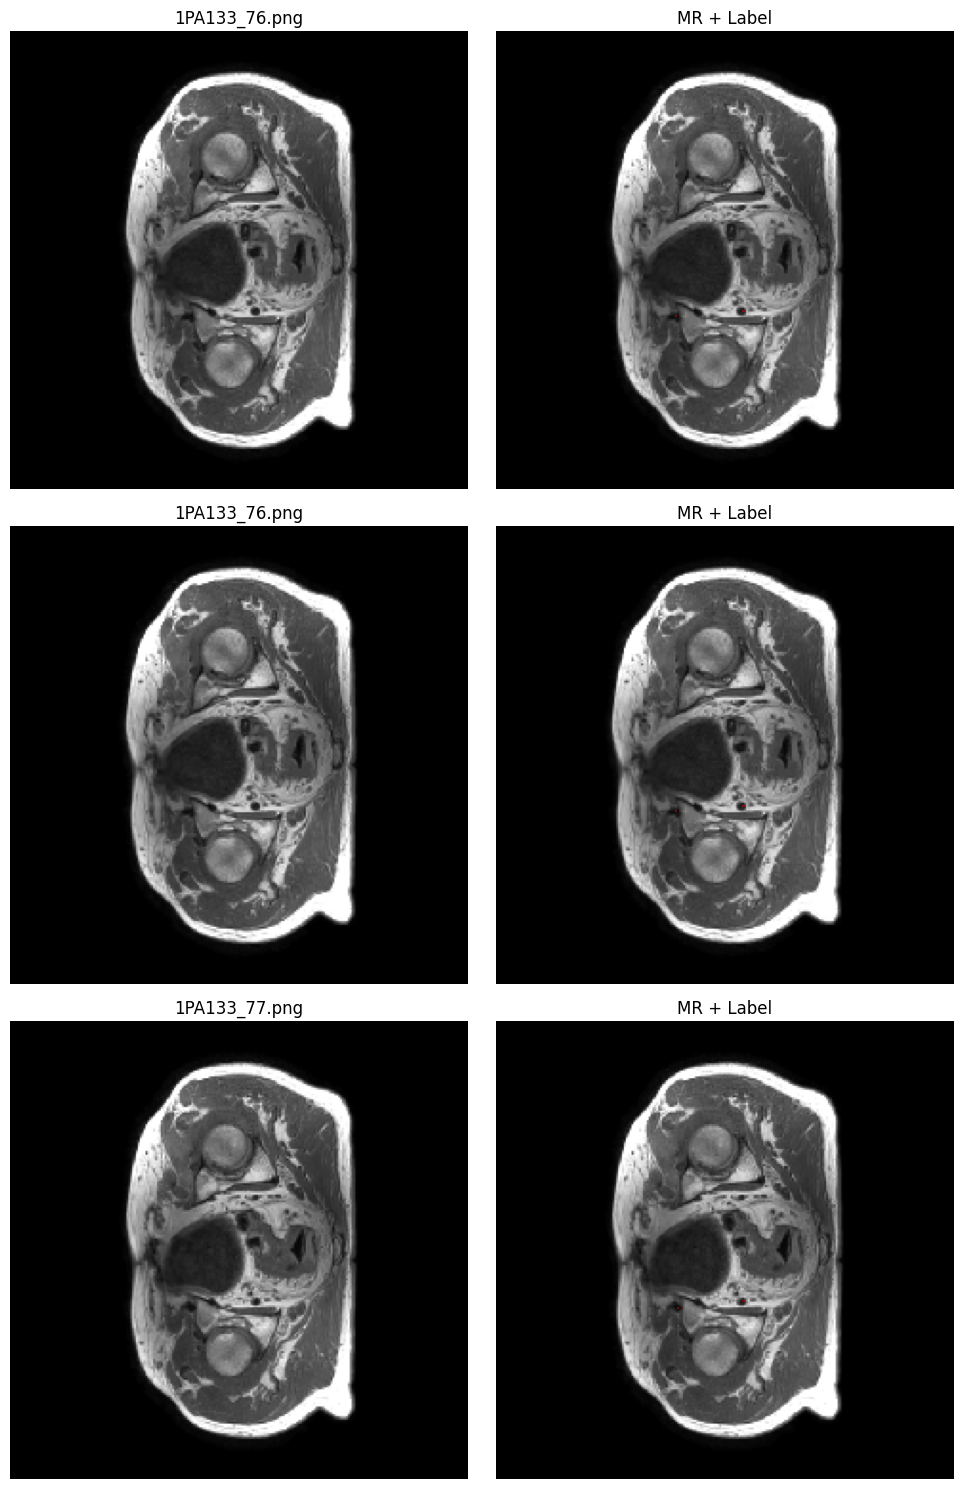

['1PA136_102', '1PA136_104', '1PA136_106']


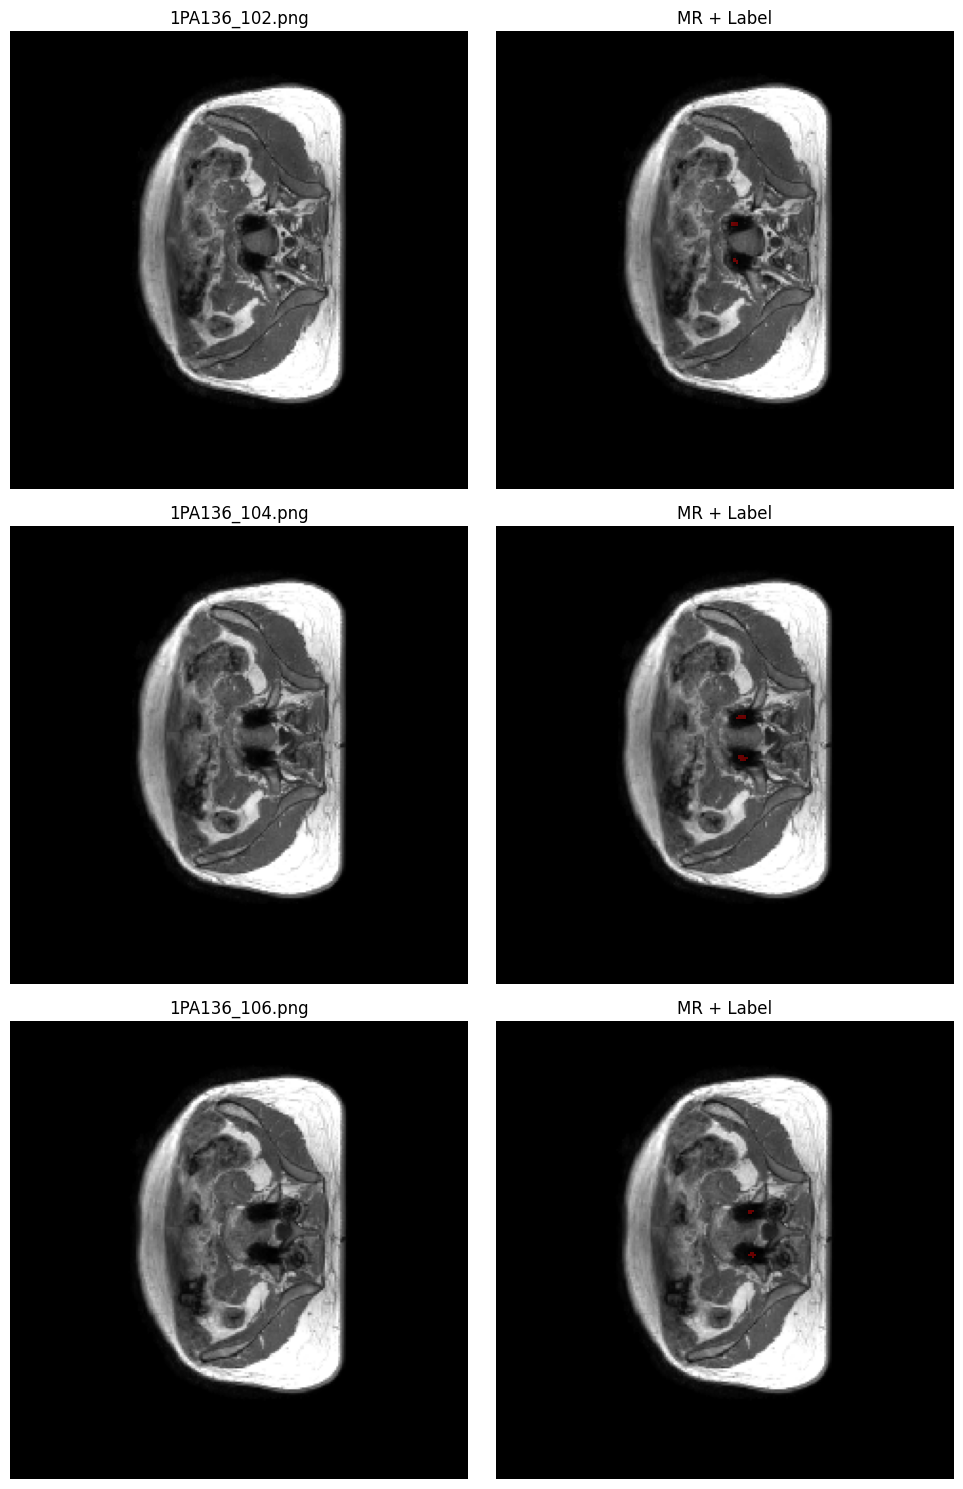

['1PA169_15', '1PA169_52', '1PA169_89']


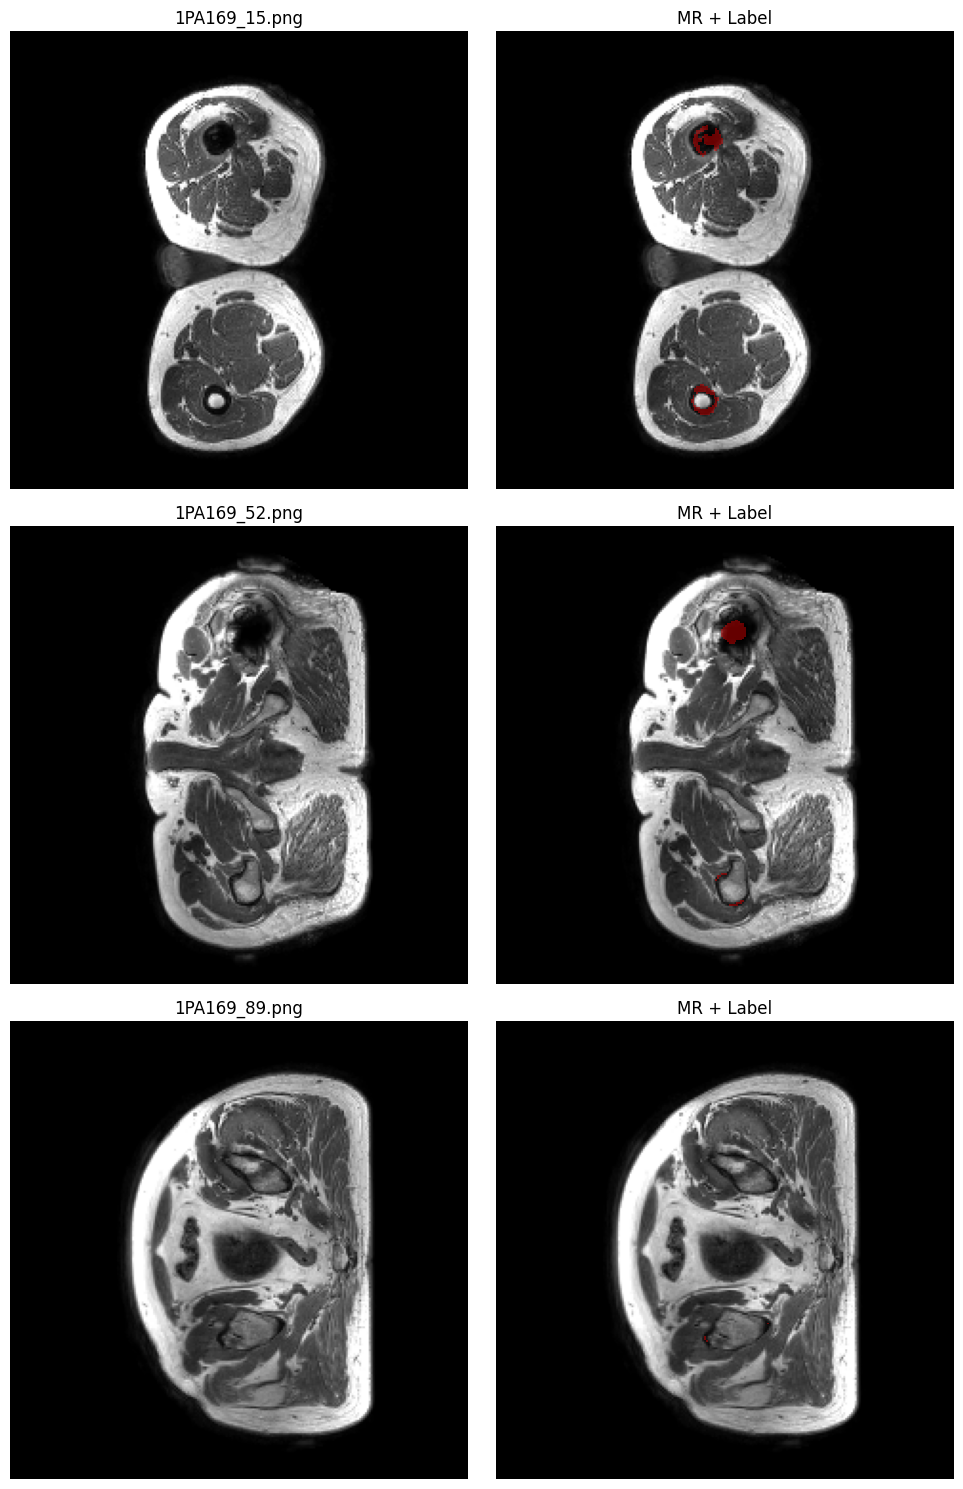

In [ ]:
import glob
ids_abnormal_valid = ["1PA133", "1PA136", "1PA169"]
for id_ in ids_abnormal_valid:
    anomaly_imgs = glob.glob(os.path.join(DIR_OUTPUT, "valid", "Ungood", "img", f"{id_}_*.png"))
    slices = [int(os.path.basename(img).split("_")[1].split(".")[0]) for img in anomaly_imgs]
    slices = np.linspace(min(slices), max(slices), num=3).astype(int)
    image_slices = [os.path.join(
        DIR_OUTPUT, "valid", "Ungood", "img", f"{id_}_{slice_}.png"
    ) for slice_ in slices]
    mask_slices = [
        os.path.join(DIR_OUTPUT, "valid", "Ungood", "label", f"{id_}_{slice_}.png")
        for slice_ in slices
    ]
    print([f"{id_}_{slice}" for slice in slices])
    plot_mr_pairs(image_slices, mask_slices, row_titles=[f"{id_}_{slice}" for slice in slices],)

In [ ]:
# zip output
# !zip -r synthrad23_metal_v2_updated.zip ../output/

updating: ../output/ (stored 0%)
updating: ../output/train/ (stored 0%)
updating: ../output/train/good/ (stored 0%)
updating: ../output/train/good/1PA101_25.png (deflated 0%)
updating: ../output/train/good/1PA101_26.png (deflated 0%)
updating: ../output/train/good/1PA101_27.png (deflated 0%)
updating: ../output/train/good/1PA101_28.png (deflated 0%)
updating: ../output/train/good/1PA101_29.png (deflated 0%)
updating: ../output/train/good/1PA101_30.png (deflated 0%)
updating: ../output/train/good/1PA101_31.png (deflated 0%)
updating: ../output/train/good/1PA101_32.png (deflated 0%)
updating: ../output/train/good/1PA101_33.png (deflated 0%)
updating: ../output/train/good/1PA101_34.png (deflated 0%)
updating: ../output/train/good/1PA101_35.png (deflated 0%)
updating: ../output/train/good/1PA101_36.png (deflated 0%)
updating: ../output/train/good/1PA101_37.png (deflated 0%)
updating: ../output/train/good/1PA101_38.png (deflated 0%)
updating: ../output/train/good/1PA101_39.png (deflated 0%)